In [ ]:
#@title Installs:

!pip install pretrainedmodels

!pip install torchlm

In [ ]:
!pip install wandb
!wandb login 22ed476c0b9f3220c32f86c9de19e34fe91112cf

In [ ]:
#!unzip "drive/MyDrive/dataset_1000.zip"
!unzip "drive/MyDrive/data/300W-Cropped.zip"

Archive:  drive/MyDrive/data/300W-Cropped.zip
   creating: 300W-Cropped/01_Indoor/
  inflating: 300W-Cropped/01_Indoor/indoor_001.png  
  inflating: 300W-Cropped/01_Indoor/indoor_001.pts  
  inflating: 300W-Cropped/01_Indoor/indoor_002.png  
  inflating: 300W-Cropped/01_Indoor/indoor_002.pts  
  inflating: 300W-Cropped/01_Indoor/indoor_003.png  
  inflating: 300W-Cropped/01_Indoor/indoor_003.pts  
  inflating: 300W-Cropped/01_Indoor/indoor_004.png  
  inflating: 300W-Cropped/01_Indoor/indoor_004.pts  
  inflating: 300W-Cropped/01_Indoor/indoor_005.png  
  inflating: 300W-Cropped/01_Indoor/indoor_005.pts  
  inflating: 300W-Cropped/01_Indoor/indoor_006.png  
  inflating: 300W-Cropped/01_Indoor/indoor_006.pts  
  inflating: 300W-Cropped/01_Indoor/indoor_007.png  
  inflating: 300W-Cropped/01_Indoor/indoor_007.pts  
  inflating: 300W-Cropped/01_Indoor/indoor_008.png  
  inflating: 300W-Cropped/01_Indoor/indoor_008.pts  
  inflating: 300W-Cropped/01_Indoor/indoor_009.png  
  inflating: 300

In [ ]:
!unzip "drive/MyDrive/data/dataset_1000.zip"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Import:

import torch
import os
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.utils.data as data
import scipy
import torch.nn.functional as F
import torchvision.transforms as T

import pretrainedmodels
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import torch.optim as one
import matplotlib
import random
import time
import logging
import torchlm
#import wandb


from PIL import Image, ImageFilter
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision import transforms
from scipy.integrate import simps
from scipy.stats import norm
from math import floor

In [ ]:
#@title Configuration:

class Config():
    def __init__(self):
        self.det_head = 'pip'
        self.net_stride = 32
        self.batch_size = 16
        self.init_lr = 0.0001
        self.num_epochs = 55
        self.decay_steps = [30, 50]
        self.input_size = 256
        self.backbone = 'resnet18'
        self.pretrained = True
        self.criterion_cls = 'l2'
        self.criterion_reg = 'l1'
        self.cls_loss_weight = 10
        self.reg_loss_weight = 1
        self.num_lms = 68
        self.save_interval = 2
        self.num_nb = 10
        self.use_gpu = True
        self.gpu_id = 0
        self.data_dir = "dataset_1000/"
        self.test_data_dir = "300W-Cropped"
        self.log_dir = "drive/MyDrive/machine-learning/"
        self.data_name = "pipnet_rn18/"
        self.experiment_name = None



cfg = Config()
cfg.experiment_name = "09"

In [ ]:
#@title Data (Augmentation) Methods:

# Augmentation methods:
def random_translate(image, target, override = False):

    if override == True or random.random() > 0.5:
        image_height, image_width = image.size
        a = 1
        b = 0
        #c = 30 #left/right (i.e. 5/-5)
        c = int((random.random()-0.5) * 60)
        d = 0
        e = 1
        #f = 30 #up/down (i.e. 5/-5)
        f = int((random.random()-0.5) * 60)
        image = image.transform(image.size, Image.AFFINE, (a, b, c, d, e, f))
        target_translate = target.copy()
        target_translate = target_translate.reshape(-1, 2)
        target_translate[:, 0] -= 1.*c/image_width
        target_translate[:, 1] -= 1.*f/image_height
        target_translate = target_translate.flatten()
        target_translate[target_translate < 0] = 0
        target_translate[target_translate > 1] = 1
        return image, target_translate
    else:
        return image, target

def random_blur(image, override = False):
    if override == True or random.random() > 0.7:
        image = image.filter(ImageFilter.GaussianBlur(random.random()*5))
    return image

def random_occlusion(image, override = False):
    if override == True or random.random() > 0.5:
        image_np = np.array(image).astype(np.uint8)
        image_np = image_np[:,:,::-1]
        image_height, image_width, _ = image_np.shape
        occ_height = int(image_height*0.4*random.random())
        occ_width = int(image_width*0.4*random.random())
        occ_xmin = int((image_width - occ_width - 10) * random.random())
        occ_ymin = int((image_height - occ_height - 10) * random.random())
        image_np[occ_ymin:occ_ymin+occ_height, occ_xmin:occ_xmin+occ_width, 0] = int(random.random() * 255)
        image_np[occ_ymin:occ_ymin+occ_height, occ_xmin:occ_xmin+occ_width, 1] = int(random.random() * 255)
        image_np[occ_ymin:occ_ymin+occ_height, occ_xmin:occ_xmin+occ_width, 2] = int(random.random() * 255)
        image_pil = Image.fromarray(image_np[:,:,::-1].astype('uint8'), 'RGB')
        return image_pil
    else:
        return image

def random_rotate(image, target, angle_max, override = False):
    if override == True or random.random() > 0.5:
        center_x = 0.5
        center_y = 0.5
        landmark_num= int(len(target) / 2)
        target_center = np.array(target) - np.array([center_x, center_y]*landmark_num)
        target_center = target_center.reshape(landmark_num, 2)
        theta_max = np.radians(angle_max)
        theta = random.uniform(-theta_max, theta_max)
        angle = np.degrees(theta)
        image = image.rotate(angle)

        c, s = np.cos(theta), np.sin(theta)
        rot = np.array(((c,-s), (s, c)))
        target_center_rot = np.matmul(target_center, rot)
        target_rot = target_center_rot.reshape(landmark_num*2) + np.array([center_x, center_y]*landmark_num)
        return image, target_rot
    else:
        return image, target

def gen_target_pip(target, meanface_indices, target_map, target_local_x, target_local_y, target_nb_x, target_nb_y):
    num_nb = len(meanface_indices[0])
    map_channel, map_height, map_width = target_map.shape
    target = target.reshape(-1, 2)
    assert map_channel == target.shape[0]

    for i in range(map_channel):
        mu_x = int(floor(target[i][0] * map_width))
        mu_y = int(floor(target[i][1] * map_height))
        mu_x = max(0, mu_x)
        mu_y = max(0, mu_y)
        mu_x = min(mu_x, map_width-1)
        mu_y = min(mu_y, map_height-1)
        target_map[i, mu_y, mu_x] = 1
        shift_x = target[i][0] * map_width - mu_x
        shift_y = target[i][1] * map_height - mu_y
        target_local_x[i, mu_y, mu_x] = shift_x
        target_local_y[i, mu_y, mu_x] = shift_y

        for j in range(num_nb):
            nb_x = target[meanface_indices[i][j]][0] * map_width - mu_x
            nb_y = target[meanface_indices[i][j]][1] * map_height - mu_y
            target_nb_x[num_nb*i+j, mu_y, mu_x] = nb_x
            target_nb_y[num_nb*i+j, mu_y, mu_x] = nb_y

    return target_map, target_local_x, target_local_y, target_nb_x, target_nb_y


In [ ]:
#@title Dataset:

class ImageFolder_pip(data.Dataset):
    def __init__(self, root, imgs, input_size, num_lms, net_stride, meanface_indices, is_training = False, transform=None, target_transform=None):
        self.root = root
        self.imgs = imgs
        self.num_lms = num_lms
        self.net_stride = net_stride
        self.meanface_indices = meanface_indices
        self.num_nb = len(meanface_indices[0])
        self.transform = transform
        self.target_transform = target_transform
        self.input_size = input_size
        self.is_training = is_training

    def __getitem__(self, index):

        img_name, target = self.imgs[index]

        img = Image.open(img_name).convert('RGB')
        

        if self.is_training:
          img, target = random_translate(img, target)
          img = random_occlusion(img)
          img, target = random_rotate(img, target, 30)
          img = random_blur(img)

        target_map = np.zeros((self.num_lms, int(self.input_size/self.net_stride), int(self.input_size/self.net_stride)))
        target_local_x = np.zeros((self.num_lms, int(self.input_size/self.net_stride), int(self.input_size/self.net_stride)))
        target_local_y = np.zeros((self.num_lms, int(self.input_size/self.net_stride), int(self.input_size/self.net_stride)))
        target_nb_x = np.zeros((self.num_nb*self.num_lms, int(self.input_size/self.net_stride), int(self.input_size/self.net_stride)))
        target_nb_y = np.zeros((self.num_nb*self.num_lms, int(self.input_size/self.net_stride), int(self.input_size/self.net_stride)))
        target_map, target_local_x, target_local_y, target_nb_x, target_nb_y = gen_target_pip(target, self.meanface_indices, target_map, target_local_x, target_local_y, target_nb_x, target_nb_y)
        
        target_map = torch.from_numpy(target_map).float()
        target_local_x = torch.from_numpy(target_local_x).float()
        target_local_y = torch.from_numpy(target_local_y).float()
        target_nb_x = torch.from_numpy(target_nb_x).float()
        target_nb_y = torch.from_numpy(target_nb_y).float()

        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target_map = self.target_transform(target_map)
            target_local_x = self.target_transform(target_local_x)
            target_local_y = self.target_transform(target_local_y)
            target_nb_x = self.target_transform(target_nb_x)
            target_nb_y = self.target_transform(target_nb_y)
        
        return img, target_map, target_local_x, target_local_y, target_nb_x, target_nb_y, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
#@title Data Annotation:

def generate_meanface():
    custom_meanface, custom_meanface_string = torchlm.data.annotools.generate_meanface(
      annotation_path="data_annotated.txt",
      coordinates_already_normalized=True)
    
    with open('meanface.txt', 'w') as f:
      f.writelines(custom_meanface_string)

    rendered_meanface = torchlm.data.annotools.draw_meanface(
      meanface=custom_meanface, coordinates_already_normalized=True)
    
    cv2.imwrite("meanface.jpg", rendered_meanface)
    
    #print(custom_meanface_string)

def get_keypoints(data_dir, file_name):
    #remove file extension from file_name
    idx = [idx for idx, x in enumerate(file_name) if x == '.']
    file_name = file_name[:idx[0]]
    #get name of keypoint file
    file_name = data_dir + file_name + "_ldmks.txt"
    #fetch file and extract keypoints as list of tuples
    keypoints = pd.read_csv(file_name, sep=" ", header=None, names=range(1,3))
    keypoints = np.array(keypoints, dtype='float32')

    return keypoints

def get_keypoints_path(file_path):

    idx = [idx for idx, x in enumerate(file_path) if x == '.']
    file_name = file_path[:idx[0]]
    file_name = str(file_name) + "_ldmks.txt"
    keypoints = pd.read_csv(file_name, sep=" ", header=None, names=range(1,3))
    keypoints = np.array(keypoints, dtype='float32')

    return keypoints



def form_datafile():
  # get all images in list:
  #im_list = np.array([])
  #for f in os.listdir(cfg.data_dir):
  #  if not '_seg' in f and not '_ldmks' in f and '.png' in f:
  #    im_list = np.append(im_list, f)

  train_list, valid_list = train_validate_split(cfg.data_dir, 0.1)

  lines = []
  for i in range(0, train_list.shape[0]):
    keypoints = get_keypoints(cfg.data_dir, train_list[i])
    keypoints = keypoints[:-2, :]
    keypoints = keypoints/512 # normalize coordinates
    keypoints = np.reshape(keypoints, (1, keypoints.shape[0]*2))
    line = ""
    for j in range(0, keypoints.shape[1]):
      val = keypoints[0,j]
      val = str(val)
      line += (" " + val) 

    if i == 0:
      lines.append(str(cfg.data_dir + train_list[i]) + line)
    else:
      lines.append("\n" + str(cfg.data_dir + train_list[i]) + line)
      
  with open('data_annotated.txt', 'w') as f:
    f.writelines(lines)


  lines = []
  for i in range(0, valid_list.shape[0]):
    keypoints = get_keypoints(cfg.data_dir, valid_list[i])
    keypoints = keypoints[:-2, :]
    keypoints = keypoints/512 # normalize coordinates
    keypoints = np.reshape(keypoints, (1, keypoints.shape[0]*2))
    line = ""
    for j in range(0, keypoints.shape[1]):
      val = keypoints[0,j]
      val = str(val)
      line += (" " + val) 

    if i == 0:
      lines.append(str(cfg.data_dir + valid_list[i]) + line)
    else:
      lines.append("\n" + str(cfg.data_dir + valid_list[i]) + line)
      
  with open('data_annotated_validation.txt', 'w') as f:
    f.writelines(lines)



form_datafile()
generate_meanface()

Generating meanface [data_annotated.txt]: 100%|██████████| 901/901 [00:00<00:00, 21074.79it/s]


In [ ]:
#@title Visualization
def show_points_validation(image, target, lms):
  target = target.cuda().detach().cpu().clone().numpy()
  image = image.cuda().detach().cpu().clone()
  img = np.array(image, dtype='float32')
  img = np.transpose(img,(1,2,0))

  plt.imshow(img)
  target = np.reshape(target,(len(target)//2, 2))
  plt.plot(target[:,0]*cfg.input_size,target[:,1]*cfg.input_size, 'bo', markersize=2)


  preds = lms.cuda().detach().cpu().clone().numpy()
  preds = np.reshape(preds, (len(preds)//2, 2))
  plt.plot(preds[:,0]*cfg.input_size,preds[:,1]*cfg.input_size, 'ro', markersize=2)


  plt.show()
  return



def dataset_keypoints_plot(data):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        image, labels_map, labels_x, labels_y, labels_nb_x, labels_nb_y, target = data[i]

        img = np.array(image, dtype='float32')
        img = np.transpose(img,(1,2,0))

        plt.imshow(img)
        target = np.reshape(target,(len(target)//2, 2))
        plt.plot(target[:,0]*cfg.input_size,target[:,1]*cfg.input_size, 'bo', markersize=2)
        plt.show()



In [ ]:
#@title Utility Functions:
def train_validate_split(folder_path, split):
  im_list = np.array([])
  for f in os.listdir(folder_path):
    if not '_seg' in f and not '_ldmks' in f and '.png' in f:
      im_list = np.append(im_list, f)
  len_data = len(im_list)
  # calculate the validation data sample length
  valid_split = int(len_data * split)
  # calculate the training data samples length
  train_split = int(len_data - valid_split)
  training_samples = im_list[:train_split]
  valid_samples = im_list[-valid_split:]
  return training_samples, valid_samples

def get_label(label_file, task_type=None):
    label_path = label_file
    with open(label_path, 'r') as f:
        labels = f.readlines()
    labels = [x.strip().split() for x in labels]
    if len(labels[0])==1:
        return labels

    labels_new = []
    for label in labels:
        image_name = label[0]
        target = label[1:]
        target = np.array([float(x) for x in target])
        if task_type is None:
            labels_new.append([image_name, target])
        else:
            labels_new.append([image_name, task_type, target])
    return labels_new

def get_meanface(meanface_file, num_nb):
    with open(meanface_file) as f:
        meanface = f.readlines()[0]
        
    meanface = meanface.strip().split()
    meanface = [float(x) for x in meanface]
    meanface = np.array(meanface).reshape(-1, 2)
    # each landmark predicts num_nb neighbors
    meanface_indices = []
    for i in range(meanface.shape[0]):
        pt = meanface[i,:]
        dists = np.sum(np.power(pt-meanface, 2), axis=1)
        indices = np.argsort(dists)
        meanface_indices.append(indices[1:1+num_nb])
    
    # each landmark predicted by X neighbors, X varies
    meanface_indices_reversed = {}
    for i in range(meanface.shape[0]):
        meanface_indices_reversed[i] = [[],[]]
    for i in range(meanface.shape[0]):
        for j in range(num_nb):
            meanface_indices_reversed[meanface_indices[i][j]][0].append(i)
            meanface_indices_reversed[meanface_indices[i][j]][1].append(j)
    
    max_len = 0
    for i in range(meanface.shape[0]):
        tmp_len = len(meanface_indices_reversed[i][0])
        if tmp_len > max_len:
            max_len = tmp_len
    
    # tricks, make them have equal length for efficient computation
    for i in range(meanface.shape[0]):
        tmp_len = len(meanface_indices_reversed[i][0])
        meanface_indices_reversed[i][0] += meanface_indices_reversed[i][0]*10
        meanface_indices_reversed[i][1] += meanface_indices_reversed[i][1]*10
        meanface_indices_reversed[i][0] = meanface_indices_reversed[i][0][:max_len]
        meanface_indices_reversed[i][1] = meanface_indices_reversed[i][1][:max_len]

    # make the indices 1-dim
    reverse_index1 = []
    reverse_index2 = []
    for i in range(meanface.shape[0]):
        reverse_index1 += meanface_indices_reversed[i][0]
        reverse_index2 += meanface_indices_reversed[i][1]
    return meanface_indices, reverse_index1, reverse_index2, max_len

def compute_loss_pip(outputs_map, outputs_local_x, outputs_local_y, outputs_nb_x, outputs_nb_y, labels_map, labels_local_x, labels_local_y, labels_nb_x, labels_nb_y,  criterion_cls, criterion_reg, num_nb):

    tmp_batch, tmp_channel, tmp_height, tmp_width = outputs_map.size()
    labels_map = labels_map.view(tmp_batch*tmp_channel, -1)
    labels_max_ids = torch.argmax(labels_map, 1)
    labels_max_ids = labels_max_ids.view(-1, 1)
    labels_max_ids_nb = labels_max_ids.repeat(1, num_nb).view(-1, 1)

    outputs_local_x = outputs_local_x.view(tmp_batch*tmp_channel, -1)
    outputs_local_x_select = torch.gather(outputs_local_x, 1, labels_max_ids)
    outputs_local_y = outputs_local_y.view(tmp_batch*tmp_channel, -1)
    outputs_local_y_select = torch.gather(outputs_local_y, 1, labels_max_ids)
    outputs_nb_x = outputs_nb_x.view(tmp_batch*num_nb*tmp_channel, -1)
    outputs_nb_x_select = torch.gather(outputs_nb_x, 1, labels_max_ids_nb)
    outputs_nb_y = outputs_nb_y.view(tmp_batch*num_nb*tmp_channel, -1)
    outputs_nb_y_select = torch.gather(outputs_nb_y, 1, labels_max_ids_nb)

    labels_local_x = labels_local_x.view(tmp_batch*tmp_channel, -1)
    labels_local_x_select = torch.gather(labels_local_x, 1, labels_max_ids)
    labels_local_y = labels_local_y.view(tmp_batch*tmp_channel, -1)
    labels_local_y_select = torch.gather(labels_local_y, 1, labels_max_ids)
    labels_nb_x = labels_nb_x.view(tmp_batch*num_nb*tmp_channel, -1)
    labels_nb_x_select = torch.gather(labels_nb_x, 1, labels_max_ids_nb)
    labels_nb_y = labels_nb_y.view(tmp_batch*num_nb*tmp_channel, -1)
    labels_nb_y_select = torch.gather(labels_nb_y, 1, labels_max_ids_nb)

    labels_map = labels_map.view(tmp_batch, tmp_channel, tmp_height, tmp_width)
    loss_map = criterion_cls(outputs_map, labels_map)
    loss_x = criterion_reg(outputs_local_x_select, labels_local_x_select)
    loss_y = criterion_reg(outputs_local_y_select, labels_local_y_select)
    loss_nb_x = criterion_reg(outputs_nb_x_select, labels_nb_x_select)
    loss_nb_y = criterion_reg(outputs_nb_y_select, labels_nb_y_select)
    return loss_map, loss_x, loss_y, loss_nb_x, loss_nb_y

def train_model(det_head, net, train_loader, valid_loader, criterion_cls, criterion_reg, cls_loss_weight, reg_loss_weight, num_nb, optimizer, num_epochs, scheduler, save_dir, save_interval, device):
    nmes = []
    losses = []
    val_losses = []
    wandb.init(project="pipnet18_domain_gap", name="pipnet18-10000-full", id="pip09", resume="must")
    wandb.config = {
      "learning_rate": cfg.init_lr,
      "epochs": num_epochs,
      "batch_size": cfg.batch_size
    }
    wandb.watch(net, criterion_cls, log="all", log_freq=1) #TODO might want to change log_freq?

    epoch_start = 48

    for epoch in range(epoch_start, num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        logging.info('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        logging.info('-' * 10)
        epoch_loss = 0.0
 
        epoch_loss = fit(net, train_loader, criterion_cls, criterion_reg, cls_loss_weight, reg_loss_weight, num_nb, optimizer, epoch, num_epochs)
        validation_loss, nme = validate(net, valid_loader, criterion_cls, criterion_reg, cls_loss_weight, reg_loss_weight, num_nb, optimizer, epoch, num_epochs)

        losses.append(epoch_loss)
        val_losses.append(validation_loss)
        nmes.append(nme)

        wandb.log({"epoch": (epoch+1),
               "train_loss": (epoch_loss),
               "val_loss": (validation_loss),
               "NME": (nme)})
        wandb.define_metric("epoch")

        if epoch%(save_interval-1) == 0 and epoch > 0:
            filename = os.path.join(save_dir, 'epoch%d.pth' % epoch)
            torch.save(net.state_dict(), filename)
            print(filename, 'saved')
        scheduler.step()

    
    plt.figure(figsize=(10, 7))
    plt.plot(losses, color='orange', label='train loss')
    plt.plot(val_losses, color='red', label='validataion loss')
    plt.plot(nmes, color='blue', label='NME')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return net

def fit(net, train_loader, criterion_cls, criterion_reg, cls_loss_weight, reg_loss_weight, num_nb, optimizer, epoch, num_epochs):
    print('Training')
    training_loss = 0.0
    net.train()
    for i, data in enumerate(train_loader):
      
        inputs, labels_map, labels_x, labels_y, labels_nb_x, labels_nb_y, target = data
        target = target.to(device)
        inputs = inputs.to(device)
        labels_map = labels_map.to(device)
        labels_x = labels_x.to(device)
        labels_y = labels_y.to(device)
        labels_nb_x = labels_nb_x.to(device)
        labels_nb_y = labels_nb_y.to(device)
        outputs_map, outputs_x, outputs_y, outputs_nb_x, outputs_nb_y = net(inputs)
        loss_map, loss_x, loss_y, loss_nb_x, loss_nb_y = compute_loss_pip(outputs_map, outputs_x, outputs_y, outputs_nb_x, outputs_nb_y, labels_map, labels_x, labels_y, labels_nb_x, labels_nb_y, criterion_cls, criterion_reg, num_nb)
        loss = cls_loss_weight*loss_map + reg_loss_weight*loss_x + reg_loss_weight*loss_y + reg_loss_weight*loss_nb_x + reg_loss_weight*loss_nb_y

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i%10 == 0:
            print('[Epoch {:d}/{:d}, Batch {:d}/{:d}] <Total training loss: {:.6f}> <map loss: {:.6f}> <x loss: {:.6f}> <y loss: {:.6f}> <nbx loss: {:.6f}> <nby loss: {:.6f}>'.format(
                epoch, num_epochs-1, i, len(train_loader)-1, loss.item(), cls_loss_weight*loss_map.item(), reg_loss_weight*loss_x.item(), reg_loss_weight*loss_y.item(), reg_loss_weight*loss_nb_x.item(), reg_loss_weight*loss_nb_y.item()))
            logging.info('[Epoch {:d}/{:d}, Batch {:d}/{:d}] <Total training loss: {:.6f}> <map loss: {:.6f}> <x loss: {:.6f}> <y loss: {:.6f}> <nbx loss: {:.6f}> <nby loss: {:.6f}>'.format(
                epoch, num_epochs-1, i, len(train_loader)-1, loss.item(), cls_loss_weight*loss_map.item(), reg_loss_weight*loss_x.item(), reg_loss_weight*loss_y.item(), reg_loss_weight*loss_nb_x.item(), reg_loss_weight*loss_nb_y.item()))
    
        training_loss += loss.item()

    return training_loss/len(train_loader)


def validate(net, valid_loader, criterion_cls, criterion_reg, cls_loss_weight, reg_loss_weight, num_nb, optimizer, epoch, num_epochs):
    print('Validating')
    validation_loss = 0.0
    net.eval()
    nme = 0.0
    for i, data in enumerate(valid_loader):
            inputs, labels_map, labels_x, labels_y, labels_nb_x, labels_nb_y, target = data
            target = target.to(device)
            inputs = inputs.to(device)
            labels_map = labels_map.to(device)
            labels_x = labels_x.to(device)
            labels_y = labels_y.to(device)
            labels_nb_x = labels_nb_x.to(device)
            labels_nb_y = labels_nb_y.to(device)
            outputs_map, outputs_x, outputs_y, outputs_nb_x, outputs_nb_y = net(inputs)
            loss_map, loss_x, loss_y, loss_nb_x, loss_nb_y = compute_loss_pip(outputs_map, outputs_x, outputs_y, outputs_nb_x, outputs_nb_y, labels_map, labels_x, labels_y, labels_nb_x, labels_nb_y, criterion_cls, criterion_reg, num_nb)
            loss = cls_loss_weight*loss_map + reg_loss_weight*loss_x + reg_loss_weight*loss_y + reg_loss_weight*loss_nb_x + reg_loss_weight*loss_nb_y

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i==0:
              # visualize:
              lms = get_landmarks(net, torch.unsqueeze(inputs[0].clone(), 0))
              nme = compute_nme_runtime(lms, target[0])
              print('NME: ', nme)
              show_points_validation(inputs[0], target[0], lms)

            if i%10 == 0:
                print('[Epoch {:d}/{:d}, Batch {:d}/{:d}] <Total validation loss: {:.6f}> <map loss: {:.6f}> <x loss: {:.6f}> <y loss: {:.6f}> <nbx loss: {:.6f}> <nby loss: {:.6f}>'.format(
                    epoch, num_epochs-1, i, len(train_loader)-1, loss.item(), cls_loss_weight*loss_map.item(), reg_loss_weight*loss_x.item(), reg_loss_weight*loss_y.item(), reg_loss_weight*loss_nb_x.item(), reg_loss_weight*loss_nb_y.item()))
                logging.info('[Epoch {:d}/{:d}, Batch {:d}/{:d}] <Total validation loss: {:.6f}> <map loss: {:.6f}> <x loss: {:.6f}> <y loss: {:.6f}> <nbx loss: {:.6f}> <nby loss: {:.6f}>'.format(
                    epoch, num_epochs-1, i, len(train_loader)-1, loss.item(), cls_loss_weight*loss_map.item(), reg_loss_weight*loss_x.item(), reg_loss_weight*loss_y.item(), reg_loss_weight*loss_nb_x.item(), reg_loss_weight*loss_nb_y.item()))
        
            validation_loss += loss.item()

    epoch_validation_loss = validation_loss/len(valid_loader)
    return epoch_validation_loss, nme


def forward_pip(net, inputs, input_size, net_stride, num_nb):
    net.eval()
    with torch.no_grad():
        outputs_cls, outputs_x, outputs_y, outputs_nb_x, outputs_nb_y = net(inputs)
        tmp_batch, tmp_channel, tmp_height, tmp_width = outputs_cls.size()
        #print(tmp_batch)
        assert tmp_batch == 1

        outputs_cls = outputs_cls.view(tmp_batch*tmp_channel, -1)
        max_ids = torch.argmax(outputs_cls, 1)
        max_cls = torch.max(outputs_cls, 1)[0]
        max_ids = max_ids.view(-1, 1)
        max_ids_nb = max_ids.repeat(1, num_nb).view(-1, 1)

        outputs_x = outputs_x.view(tmp_batch*tmp_channel, -1)
        outputs_x_select = torch.gather(outputs_x, 1, max_ids)
        outputs_x_select = outputs_x_select.squeeze(1)
        outputs_y = outputs_y.view(tmp_batch*tmp_channel, -1)
        outputs_y_select = torch.gather(outputs_y, 1, max_ids)
        outputs_y_select = outputs_y_select.squeeze(1)

        outputs_nb_x = outputs_nb_x.view(tmp_batch*num_nb*tmp_channel, -1)
        outputs_nb_x_select = torch.gather(outputs_nb_x, 1, max_ids_nb)
        outputs_nb_x_select = outputs_nb_x_select.squeeze(1).view(-1, num_nb)
        outputs_nb_y = outputs_nb_y.view(tmp_batch*num_nb*tmp_channel, -1)
        outputs_nb_y_select = torch.gather(outputs_nb_y, 1, max_ids_nb)
        outputs_nb_y_select = outputs_nb_y_select.squeeze(1).view(-1, num_nb)

        tmp_x = (max_ids%tmp_width).view(-1,1).float()+outputs_x_select.view(-1,1)
        tmp_y = (max_ids//tmp_width).view(-1,1).float()+outputs_y_select.view(-1,1)
        tmp_x /= 1.0 * input_size / net_stride
        tmp_y /= 1.0 * input_size / net_stride

        tmp_nb_x = (max_ids%tmp_width).view(-1,1).float()+outputs_nb_x_select
        tmp_nb_y = (max_ids//tmp_width).view(-1,1).float()+outputs_nb_y_select
        tmp_nb_x = tmp_nb_x.view(-1, num_nb)
        tmp_nb_y = tmp_nb_y.view(-1, num_nb)
        tmp_nb_x /= 1.0 * input_size / net_stride
        tmp_nb_y /= 1.0 * input_size / net_stride

    return tmp_x, tmp_y, tmp_nb_x, tmp_nb_y, outputs_cls, max_cls


def get_landmarks(net, inputs):

    lms_pred_x, lms_pred_y, lms_pred_nb_x, lms_pred_nb_y, outputs_cls, max_cls = forward_pip(net, inputs, cfg.input_size, cfg.net_stride, cfg.num_nb)

    # merge neighbor predictions
    lms_pred = torch.cat((lms_pred_x, lms_pred_y), dim=1).flatten()
    tmp_nb_x = lms_pred_nb_x[reverse_index1, reverse_index2].view(cfg.num_lms, max_len)
    tmp_nb_y = lms_pred_nb_y[reverse_index1, reverse_index2].view(cfg.num_lms, max_len)
    tmp_x = torch.mean(torch.cat((lms_pred_x, tmp_nb_x), dim=1), dim=1).view(-1,1)
    tmp_y = torch.mean(torch.cat((lms_pred_y, tmp_nb_y), dim=1), dim=1).view(-1,1)
    lms_pred_merge = torch.cat((tmp_x, tmp_y), dim=1).flatten()

    return lms_pred_merge


def compute_nme(lms_pred, lms_gt, norm):
    lms_pred = lms_pred.reshape((-1, 2))
    lms_gt = lms_gt.reshape((-1, 2))
    #print(np.linalg.norm(lms_pred - lms_gt, axis=1));
    nme = np.mean(np.linalg.norm(lms_pred - lms_gt, axis=1)) / norm 
    return nme

def compute_nme_runtime(lms_pred, target):
    target = target.cuda().detach().cpu().clone().numpy()
    target = np.reshape(target,(len(target)//2, 2))
    
    preds = lms_pred.cuda().detach().cpu().clone().numpy()
    preds = np.reshape(preds, (len(preds)//2, 2))

    norm = np.linalg.norm(target[36, ] - target[45, ])

    nme = np.mean(np.linalg.norm(preds - target, axis=1)) / norm 
    return nme

def compute_fr_and_auc(nmes, thres=0.1, step=0.0001):
    num_data = len(nmes)
    xs = np.arange(0, thres + step, step)
    ys = np.array([np.count_nonzero(nmes <= x) for x in xs]) / float(num_data)
    fr = 1.0 - ys[-1]
    auc = simps(ys, x=xs) / thres
    return fr, auc



In [ ]:
#@title Model:
class Pip_resnet18(nn.Module):
    def __init__(self, resnet, num_nb, num_lms=68, input_size=256, net_stride=32):
        super(Pip_resnet18, self).__init__()
        self.num_nb = num_nb
        self.num_lms = num_lms
        self.input_size = input_size
        self.net_stride = net_stride
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.maxpool = resnet.maxpool
        self.sigmoid = nn.Sigmoid()
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        if self.net_stride == 128:
            self.layer5 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
            self.bn5 = nn.BatchNorm2d(512)
            self.layer6 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
            self.bn6 = nn.BatchNorm2d(512)
            # init
            nn.init.normal_(self.layer5.weight, std=0.001)
            if self.layer5.bias is not None:
                nn.init.constant_(self.layer5.bias, 0)
            nn.init.constant_(self.bn5.weight, 1)
            nn.init.constant_(self.bn5.bias, 0)

            nn.init.normal_(self.layer6.weight, std=0.001)
            if self.layer6.bias is not None:
                nn.init.constant_(self.layer6.bias, 0)
            nn.init.constant_(self.bn6.weight, 1)
            nn.init.constant_(self.bn6.bias, 0)
        elif self.net_stride == 64:
            self.layer5 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
            self.bn5 = nn.BatchNorm2d(512)
            # init
            nn.init.normal_(self.layer5.weight, std=0.001)
            if self.layer5.bias is not None:
                nn.init.constant_(self.layer5.bias, 0)
            nn.init.constant_(self.bn5.weight, 1)
            nn.init.constant_(self.bn5.bias, 0)
        elif self.net_stride == 32:
            pass
        elif self.net_stride == 16:
            self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False)
            self.bn_deconv1 = nn.BatchNorm2d(512)
            nn.init.normal_(self.deconv1.weight, std=0.001)
            if self.deconv1.bias is not None:
                nn.init.constant_(self.deconv1.bias, 0)
            nn.init.constant_(self.bn_deconv1.weight, 1)
            nn.init.constant_(self.bn_deconv1.bias, 0)
        else:
            print('No such net_stride!')
            exit(0)

        self.cls_layer = nn.Conv2d(512, num_lms, kernel_size=1, stride=1, padding=0)
        self.x_layer = nn.Conv2d(512, num_lms, kernel_size=1, stride=1, padding=0)
        self.y_layer = nn.Conv2d(512, num_lms, kernel_size=1, stride=1, padding=0)
        self.nb_x_layer = nn.Conv2d(512, num_nb*num_lms, kernel_size=1, stride=1, padding=0)
        self.nb_y_layer = nn.Conv2d(512, num_nb*num_lms, kernel_size=1, stride=1, padding=0)

        nn.init.normal_(self.cls_layer.weight, std=0.001)
        if self.cls_layer.bias is not None:
            nn.init.constant_(self.cls_layer.bias, 0)

        nn.init.normal_(self.x_layer.weight, std=0.001)
        if self.x_layer.bias is not None:
            nn.init.constant_(self.x_layer.bias, 0)

        nn.init.normal_(self.y_layer.weight, std=0.001)
        if self.y_layer.bias is not None:
            nn.init.constant_(self.y_layer.bias, 0)

        nn.init.normal_(self.nb_x_layer.weight, std=0.001)
        if self.nb_x_layer.bias is not None:
            nn.init.constant_(self.nb_x_layer.bias, 0)

        nn.init.normal_(self.nb_y_layer.weight, std=0.001)
        if self.nb_y_layer.bias is not None:
            nn.init.constant_(self.nb_y_layer.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        if self.net_stride == 128:
            x = F.relu(self.bn5(self.layer5(x)))
            x = F.relu(self.bn6(self.layer6(x)))
        elif self.net_stride == 64:
            x = F.relu(self.bn5(self.layer5(x)))
        elif self.net_stride == 16:
            x = F.relu(self.bn_deconv1(self.deconv1(x)))
        else:
            pass
        x1 = self.cls_layer(x)
        x2 = self.x_layer(x)
        x3 = self.y_layer(x)
        x4 = self.nb_x_layer(x)
        x5 = self.nb_y_layer(x)
        return x1, x2, x3, x4, x5

In [ ]:
#@title Training:

load_weights = True

# directory initiation:
if not os.path.exists(os.path.join(cfg.log_dir, cfg.data_name)):
    os.mkdir(os.path.join(cfg.log_dir, cfg.data_name))

save_dir = os.path.join(cfg.log_dir, cfg.data_name, cfg.experiment_name)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

if not os.path.exists(os.path.join(save_dir, '/logs/')):
    os.mkdir(os.path.join(save_dir, '/logs/'))

log_dir = os.path.join(save_dir, '/logs/', cfg.experiment_name)
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

# logging:
logging.basicConfig(filename=os.path.join(log_dir, 'train.log'), level=logging.INFO)


meanface_indices, reverse_index1, reverse_index2, max_len = get_meanface('meanface.txt', cfg.num_nb)

if cfg.backbone == 'resnet18':
  resnet18 = models.resnet18(pretrained=cfg.pretrained)
  net = Pip_resnet18(resnet18, cfg.num_nb, num_lms=cfg.num_lms, input_size=cfg.input_size, net_stride=cfg.net_stride)
  if (load_weights):
    weight_file = 'drive/MyDrive/epoch47.pth'
    state_dict = torch.load(weight_file)
    net.load_state_dict(state_dict)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
net = net.to(device)

criterion_cls = None
if cfg.criterion_cls == 'l2':
    criterion_cls = nn.MSELoss()
elif cfg.criterion_cls == 'l1':
    criterion_cls = nn.L1Loss()

criterion_reg = None
if cfg.criterion_reg == 'l1':
    criterion_reg = nn.L1Loss()
elif cfg.criterion_reg == 'l2':
    criterion_reg = nn.MSELoss()


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

if cfg.pretrained:  
    optimizer = optim.Adam(net.parameters(), lr=cfg.init_lr)
else:
    optimizer = optim.Adam(net.parameters(), lr=cfg.init_lr, weight_decay=5e-4)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=cfg.decay_steps, gamma=0.1)

labels_train = get_label("data_annotated.txt")
labels_validate = get_label("data_annotated_validation.txt")

if cfg.det_head == 'pip':
    train_data = ImageFolder_pip(cfg.data_dir, 
                            labels_train, cfg.input_size, cfg.num_lms, 
                            cfg.net_stride, meanface_indices, True,
                            transforms.Compose([
                            transforms.RandomGrayscale(0.2),
                            transforms.Resize(cfg.input_size),
                            transforms.ToTensor(),
                            normalize]))
    
    valid_data = ImageFolder_pip(cfg.data_dir, 
                            labels_validate, cfg.input_size, cfg.num_lms, 
                            cfg.net_stride, meanface_indices, False,
                            transforms.Compose([
                            #transforms.RandomGrayscale(0.2),
                            transforms.Resize(cfg.input_size),
                            transforms.ToTensor(),
                            normalize
                            ]))
    
else:
    print('No such head:', cfg.det_head)
    exit(0)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)


train_model(cfg.det_head, net, train_loader, valid_loader, criterion_cls, criterion_reg, cfg.cls_loss_weight, cfg.reg_loss_weight, cfg.num_nb, optimizer, cfg.num_epochs, scheduler, save_dir, cfg.save_interval, device)



/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


True
Time taken for inference of image: 15.335359573364258


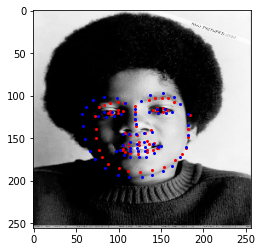

NME Value: 0.06661042729321497
Time taken for inference of image: 33.033504486083984
Time taken for inference of image: 31.1724796295166
Time taken for inference of image: 15.396896362304688
Time taken for inference of image: 33.15689468383789
Time taken for inference of image: 22.188800811767578
Time taken for inference of image: 34.336097717285156
Time taken for inference of image: 30.19206428527832
Time taken for inference of image: 35.02102279663086
Time taken for inference of image: 28.74844741821289
Time taken for inference of image: 20.518207550048828
Time taken for inference of image: 15.10912036895752
Time taken for inference of image: 10.584575653076172
Time taken for inference of image: 10.691167831420898
Time taken for inference of image: 14.690431594848633
Time taken for inference of image: 10.376383781433105
Time taken for inference of image: 8.708928108215332
Time taken for inference of image: 8.954143524169922
Time taken for inference of image: 8.723936080932617
Time ta

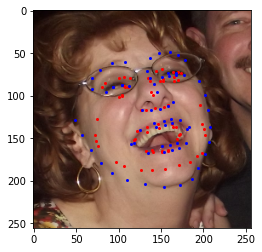

NME Value: 0.14571875596484002
Time taken for inference of image: 11.679967880249023
Time taken for inference of image: 8.934847831726074
Time taken for inference of image: 8.720255851745605
Time taken for inference of image: 9.235008239746094
Time taken for inference of image: 8.728384017944336
Time taken for inference of image: 11.197983741760254
Time taken for inference of image: 8.520928382873535
Time taken for inference of image: 8.76585578918457
Time taken for inference of image: 8.746432304382324
Time taken for inference of image: 8.518943786621094
Time taken for inference of image: 8.620896339416504
Time taken for inference of image: 8.471296310424805
Time taken for inference of image: 8.53059196472168
Time taken for inference of image: 8.844544410705566
Time taken for inference of image: 9.296095848083496
Time taken for inference of image: 8.449952125549316
Time taken for inference of image: 8.561535835266113
Time taken for inference of image: 8.90009593963623
Time taken for i

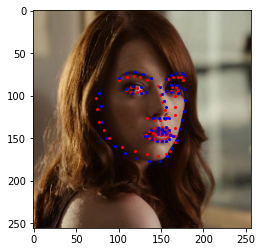

NME Value: 0.08009444580951418
Time taken for inference of image: 10.835007667541504
Time taken for inference of image: 9.050527572631836
Time taken for inference of image: 9.010656356811523
Time taken for inference of image: 8.76905632019043
Time taken for inference of image: 10.282976150512695
Time taken for inference of image: 8.70297622680664
Time taken for inference of image: 10.79423999786377
Time taken for inference of image: 9.058815956115723
Time taken for inference of image: 8.66659164428711
Time taken for inference of image: 8.56499195098877
Time taken for inference of image: 8.808416366577148
Time taken for inference of image: 8.64851188659668
Time taken for inference of image: 8.658495903015137
Time taken for inference of image: 10.159551620483398
Time taken for inference of image: 9.150976181030273
Time taken for inference of image: 8.714079856872559
Time taken for inference of image: 9.157471656799316
Time taken for inference of image: 8.565983772277832
Time taken for in

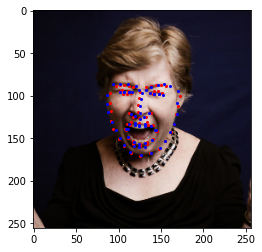

NME Value: 0.06041919030728016
Time taken for inference of image: 8.992351531982422
Time taken for inference of image: 8.777759552001953
Time taken for inference of image: 8.751104354858398
Time taken for inference of image: 8.666912078857422
Time taken for inference of image: 9.023776054382324
Time taken for inference of image: 8.631999969482422
Time taken for inference of image: 11.194144248962402
Time taken for inference of image: 8.61193561553955
Time taken for inference of image: 8.428031921386719
Time taken for inference of image: 8.46787166595459
Time taken for inference of image: 8.39027214050293
Time taken for inference of image: 8.62435245513916
Time taken for inference of image: 8.326111793518066
Time taken for inference of image: 8.51961612701416
Time taken for inference of image: 8.652064323425293
Time taken for inference of image: 8.603072166442871
Time taken for inference of image: 8.591456413269043
Time taken for inference of image: 8.723936080932617
Time taken for infe

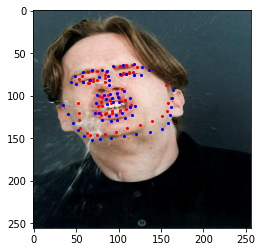

NME Value: 0.0879002077802249
Time taken for inference of image: 10.463359832763672
Time taken for inference of image: 8.762720108032227
Time taken for inference of image: 8.841279983520508
Time taken for inference of image: 8.667008399963379
Time taken for inference of image: 8.831839561462402
Time taken for inference of image: 8.669631958007812
Time taken for inference of image: 8.78985595703125
Time taken for inference of image: 9.17251205444336
Time taken for inference of image: 8.74118423461914
Time taken for inference of image: 8.819135665893555
Time taken for inference of image: 9.36508846282959
Time taken for inference of image: 10.658304214477539
Time taken for inference of image: 11.490495681762695
Time taken for inference of image: 8.570207595825195
Time taken for inference of image: 8.699647903442383
Time taken for inference of image: 8.888895988464355
Time taken for inference of image: 10.279711723327637
Time taken for inference of image: 9.978912353515625
Time taken for i

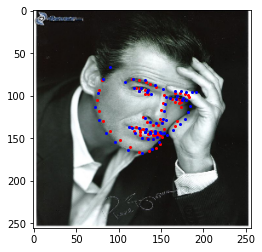

NME Value: 0.0961829199333667
Time taken for inference of image: 10.530207633972168
Time taken for inference of image: 9.050687789916992
Time taken for inference of image: 9.10870361328125
Time taken for inference of image: 9.088671684265137
Time taken for inference of image: 9.037664413452148
Time taken for inference of image: 8.853343963623047
Time taken for inference of image: 11.369855880737305
Time taken for inference of image: 8.775775909423828
Time taken for inference of image: 8.661312103271484
Time taken for inference of image: 8.745247840881348
Time taken for inference of image: 8.776191711425781
Time taken for inference of image: 9.206879615783691
Time taken for inference of image: 8.803584098815918
Time taken for inference of image: 8.570943832397461
Time taken for inference of image: 8.687040328979492
Time taken for inference of image: 8.608896255493164
Time taken for inference of image: 8.642911911010742
Time taken for inference of image: 8.671104431152344
Time taken for 

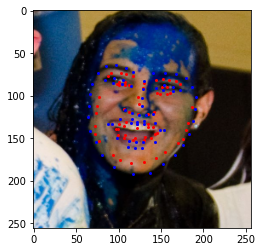

NME Value: 0.09246479810743621
Time taken for inference of image: 10.592543601989746
Time taken for inference of image: 8.857151985168457
Time taken for inference of image: 9.036735534667969
Time taken for inference of image: 8.828319549560547
Time taken for inference of image: 11.604479789733887
Time taken for inference of image: 8.615167617797852
Time taken for inference of image: 8.347711563110352
Time taken for inference of image: 8.485343933105469
Time taken for inference of image: 8.754176139831543
Time taken for inference of image: 8.433088302612305
Time taken for inference of image: 10.290687561035156
Time taken for inference of image: 9.931679725646973
Time taken for inference of image: 8.636672019958496
Time taken for inference of image: 8.659744262695312
Time taken for inference of image: 8.67039966583252
Time taken for inference of image: 8.839103698730469
Time taken for inference of image: 8.569055557250977
Time taken for inference of image: 8.431455612182617
Time taken fo

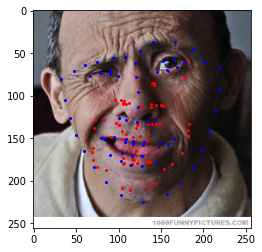

NME Value: 0.3366977386042762
Time taken for inference of image: 11.974783897399902
Time taken for inference of image: 12.279680252075195
Time taken for inference of image: 9.148096084594727
Time taken for inference of image: 9.278464317321777
Time taken for inference of image: 8.947872161865234
Time taken for inference of image: 9.346719741821289
Time taken for inference of image: 9.726847648620605
Time taken for inference of image: 11.247200012207031
Time taken for inference of image: 9.112480163574219
Time taken for inference of image: 8.8951997756958
Time taken for inference of image: 8.94825553894043
Time taken for inference of image: 9.026880264282227
Time taken for inference of image: 8.9651517868042
Time taken for inference of image: 8.704352378845215
Time taken for inference of image: 8.952544212341309
Time taken for inference of image: 8.924223899841309
Time taken for inference of image: 9.26966381072998
Time taken for inference of image: 8.757599830627441
Time taken for infe

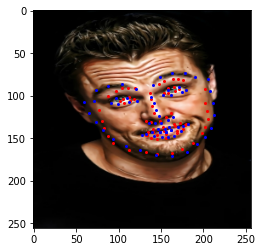

NME Value: 0.08544798104708479
Time taken for inference of image: 10.41113567352295
Time taken for inference of image: 11.055935859680176
Time taken for inference of image: 8.875679969787598
Time taken for inference of image: 9.107295989990234
Time taken for inference of image: 9.151583671569824
Time taken for inference of image: 9.062496185302734
Time taken for inference of image: 9.00169563293457
Time taken for inference of image: 9.105504035949707
Time taken for inference of image: 8.946816444396973
Time taken for inference of image: 12.506719589233398
Time taken for inference of image: 8.743840217590332
Time taken for inference of image: 9.127679824829102
Time taken for inference of image: 8.732352256774902
Time taken for inference of image: 8.908736228942871
Time taken for inference of image: 8.772192001342773
Time taken for inference of image: 11.153663635253906
Time taken for inference of image: 8.946720123291016
Time taken for inference of image: 8.669407844543457
Time taken fo

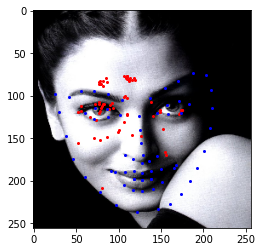

NME Value: 0.5186633568695924
Time taken for inference of image: 9.80128002166748
Time taken for inference of image: 9.099807739257812
Time taken for inference of image: 10.556639671325684
Time taken for inference of image: 8.763968467712402
Time taken for inference of image: 10.615167617797852
Time taken for inference of image: 9.118080139160156
Time taken for inference of image: 9.710847854614258
Time taken for inference of image: 8.676575660705566
Time taken for inference of image: 9.120415687561035
Time taken for inference of image: 8.89628791809082
Time taken for inference of image: 9.061280250549316
Time taken for inference of image: 8.824352264404297
Time taken for inference of image: 9.608768463134766
Time taken for inference of image: 9.340160369873047
Time taken for inference of image: 9.10364818572998
Time taken for inference of image: 8.867039680480957
Time taken for inference of image: 8.733663558959961
Time taken for inference of image: 8.648736000061035
Time taken for in

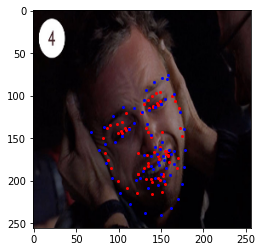

NME Value: 0.12569440780269875
Time taken for inference of image: 10.213600158691406
Time taken for inference of image: 8.944671630859375
Time taken for inference of image: 8.771360397338867
Time taken for inference of image: 8.853759765625
Time taken for inference of image: 8.931039810180664
Time taken for inference of image: 8.723487854003906
Time taken for inference of image: 9.027071952819824
Time taken for inference of image: 8.667136192321777
Time taken for inference of image: 9.152704238891602
Time taken for inference of image: 8.78166389465332
Time taken for inference of image: 9.132800102233887
Time taken for inference of image: 8.819647789001465
Time taken for inference of image: 8.861056327819824
Time taken for inference of image: 9.40998363494873
Time taken for inference of image: 9.399519920349121
Time taken for inference of image: 9.276127815246582
Time taken for inference of image: 8.895936012268066
Time taken for inference of image: 9.543295860290527
Time taken for infe

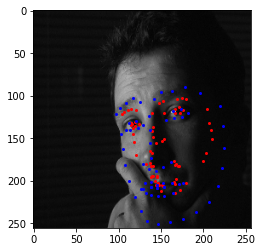

NME Value: 0.25902249325444004
Time taken for inference of image: 10.718879699707031
Time taken for inference of image: 9.032159805297852
Time taken for inference of image: 9.179424285888672
Time taken for inference of image: 8.894240379333496
Time taken for inference of image: 9.17471981048584
Time taken for inference of image: 8.985631942749023
Time taken for inference of image: 26.653663635253906
Time taken for inference of image: 9.244671821594238
Time taken for inference of image: 9.788448333740234
Time taken for inference of image: 9.03279972076416
Time taken for inference of image: 8.875871658325195
Time taken for inference of image: 10.39913558959961
Time taken for inference of image: 9.226655960083008
Time taken for inference of image: 9.37775993347168
Time taken for inference of image: 9.453791618347168
Time taken for inference of image: 9.04201602935791
Time taken for inference of image: 9.12399959564209
Time taken for inference of image: 9.365152359008789
Time taken for inf

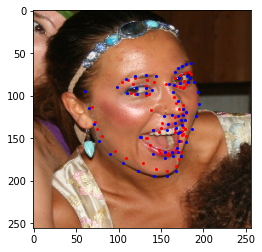

NME Value: 0.10511088484613716
Time taken for inference of image: 10.82646369934082
Time taken for inference of image: 9.356224060058594
Time taken for inference of image: 9.37177562713623
Time taken for inference of image: 8.857088088989258
Time taken for inference of image: 8.96332836151123
Time taken for inference of image: 8.89958381652832
Time taken for inference of image: 9.06054401397705
Time taken for inference of image: 9.691519737243652
Time taken for inference of image: 8.86457633972168
Time taken for inference of image: 8.713664054870605
Time taken for inference of image: 8.853311538696289
Time taken for inference of image: 8.87292766571045
Time taken for inference of image: 9.065567970275879
Time taken for inference of image: 8.819680213928223
Time taken for inference of image: 8.898816108703613
Time taken for inference of image: 10.09062385559082
Time taken for inference of image: 9.363136291503906
Time taken for inference of image: 9.033599853515625
Time taken for infere

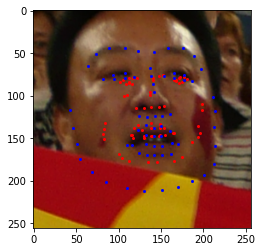

NME Value: 0.19781068247785727
Time taken for inference of image: 11.353440284729004
Time taken for inference of image: 10.713151931762695
Time taken for inference of image: 8.936832427978516
Time taken for inference of image: 8.825504302978516
Time taken for inference of image: 8.681983947753906
Time taken for inference of image: 8.811327934265137
Time taken for inference of image: 8.784192085266113
Time taken for inference of image: 8.784768104553223
Time taken for inference of image: 9.689215660095215
Time taken for inference of image: 9.174240112304688
Time taken for inference of image: 9.050463676452637
Time taken for inference of image: 8.880864143371582
Time taken for inference of image: 9.068191528320312
Time taken for inference of image: 9.279104232788086
Time taken for inference of image: 8.892095565795898
Time taken for inference of image: 11.477855682373047
Time taken for inference of image: 8.963040351867676
Time taken for inference of image: 9.098784446716309
Time taken f

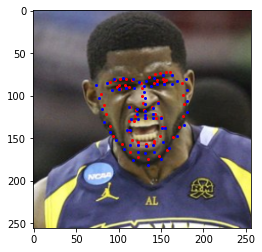

NME Value: 0.07840999104852053
Time taken for inference of image: 10.133695602416992
Time taken for inference of image: 8.760255813598633
Time taken for inference of image: 8.823360443115234
Time taken for inference of image: 9.187423706054688
Time taken for inference of image: 8.829567909240723
Time taken for inference of image: 8.956928253173828
Time taken for inference of image: 9.012063980102539
Time taken for inference of image: 10.8472318649292
Time taken for inference of image: 9.000864028930664
Time taken for inference of image: 9.02899169921875
Time taken for inference of image: 8.808768272399902
Time taken for inference of image: 8.633024215698242
Time taken for inference of image: 8.58233642578125
Time taken for inference of image: 8.670687675476074
Time taken for inference of image: 8.691871643066406
Time taken for inference of image: 8.738176345825195
Time taken for inference of image: 10.025888442993164
Time taken for inference of image: 8.813695907592773
Time taken for i

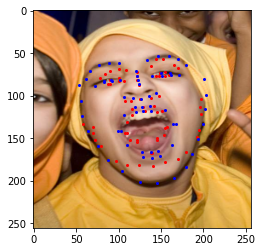

NME Value: 0.10823284110064152
Time taken for inference of image: 11.0697603225708
Time taken for inference of image: 11.179167747497559
Time taken for inference of image: 8.876704216003418
Time taken for inference of image: 8.707839965820312
Time taken for inference of image: 8.850432395935059
Time taken for inference of image: 8.670463562011719
Time taken for inference of image: 8.74953556060791
Time taken for inference of image: 8.709471702575684
Time taken for inference of image: 8.619392395019531
Time taken for inference of image: 10.467647552490234
Time taken for inference of image: 9.281344413757324
Time taken for inference of image: 8.731807708740234
Time taken for inference of image: 8.771167755126953
Time taken for inference of image: 8.649151802062988
Time taken for inference of image: 8.86473560333252
Time taken for inference of image: 8.774687767028809
Time taken for inference of image: 8.878080368041992
Time taken for inference of image: 8.916223526000977
Time taken for i

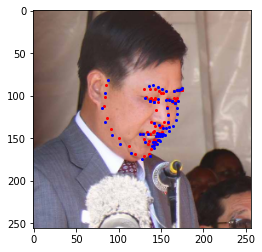

NME Value: 0.15836224105740598
Time taken for inference of image: 10.3985595703125
Time taken for inference of image: 10.006112098693848
Time taken for inference of image: 9.64083194732666
Time taken for inference of image: 8.824224472045898
Time taken for inference of image: 8.621248245239258
Time taken for inference of image: 8.869471549987793
Time taken for inference of image: 9.290271759033203
Time taken for inference of image: 8.902303695678711
Time taken for inference of image: 8.70963191986084
Time taken for inference of image: 8.638336181640625
Time taken for inference of image: 9.021471977233887
Time taken for inference of image: 8.804863929748535
Time taken for inference of image: 8.573344230651855
Time taken for inference of image: 8.531968116760254
Time taken for inference of image: 8.540608406066895
Time taken for inference of image: 8.498111724853516
Time taken for inference of image: 9.302528381347656
Time taken for inference of image: 8.519488334655762
Time taken for in

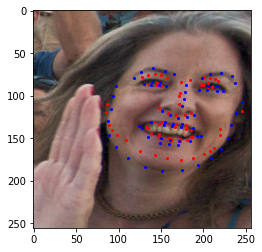

NME Value: 0.09667403322254262
Time taken for inference of image: 10.205439567565918
Time taken for inference of image: 11.03110408782959
Time taken for inference of image: 10.394111633300781
Time taken for inference of image: 10.327648162841797
Time taken for inference of image: 8.696063995361328
Time taken for inference of image: 8.785440444946289
Time taken for inference of image: 9.001664161682129
Time taken for inference of image: 10.339072227478027
Time taken for inference of image: 9.133472442626953
Time taken for inference of image: 8.967103958129883
Time taken for inference of image: 10.283519744873047
Time taken for inference of image: 9.412832260131836
Time taken for inference of image: 8.81817626953125
Time taken for inference of image: 8.87673568725586
Time taken for inference of image: 10.193568229675293
Time taken for inference of image: 9.215456008911133
Time taken for inference of image: 8.890815734863281
Time taken for inference of image: 8.793824195861816
Time taken 

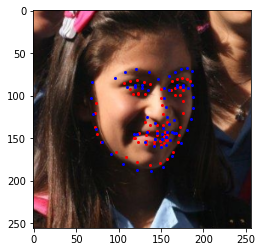

NME Value: 0.13581166611573284
Time taken for inference of image: 10.342752456665039
Time taken for inference of image: 10.136704444885254
Time taken for inference of image: 8.931424140930176
Time taken for inference of image: 8.591039657592773
Time taken for inference of image: 9.05123233795166
Time taken for inference of image: 9.087103843688965
Time taken for inference of image: 8.57862377166748
Time taken for inference of image: 9.100255966186523
Time taken for inference of image: 9.132831573486328
Time taken for inference of image: 10.143391609191895
Time taken for inference of image: 9.89078426361084
Time taken for inference of image: 8.41801643371582
Time taken for inference of image: 8.516032218933105
Time taken for inference of image: 8.653056144714355
Time taken for inference of image: 8.581536293029785
Time taken for inference of image: 8.661439895629883
Time taken for inference of image: 8.521632194519043
Time taken for inference of image: 8.989215850830078
Time taken for i

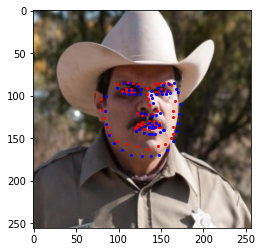

NME Value: 0.11722227813363062
Time taken for inference of image: 10.546784400939941
Time taken for inference of image: 11.147456169128418
Time taken for inference of image: 9.061311721801758
Time taken for inference of image: 8.43939208984375
Time taken for inference of image: 8.469183921813965
Time taken for inference of image: 10.077280044555664
Time taken for inference of image: 8.904128074645996
Time taken for inference of image: 11.19654369354248
Time taken for inference of image: 9.44326400756836
Time taken for inference of image: 8.58240032196045
Time taken for inference of image: 8.674495697021484
Time taken for inference of image: 8.819071769714355
Time taken for inference of image: 9.107263565063477
Time taken for inference of image: 8.820768356323242
Time taken for inference of image: 8.757856369018555
Time taken for inference of image: 8.74396800994873
Time taken for inference of image: 10.154080390930176
Time taken for inference of image: 9.928128242492676
Time taken for 

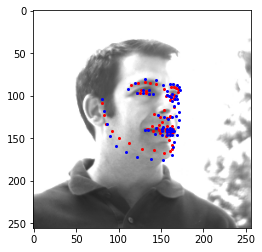

NME Value: 0.11607465530898187
Time taken for inference of image: 10.44985580444336
Time taken for inference of image: 10.376511573791504
Time taken for inference of image: 10.19711971282959
Time taken for inference of image: 8.869791984558105
Time taken for inference of image: 8.700544357299805
Time taken for inference of image: 8.797311782836914
Time taken for inference of image: 8.73481559753418
Time taken for inference of image: 8.736191749572754
Time taken for inference of image: 9.886655807495117
Time taken for inference of image: 8.670463562011719
Time taken for inference of image: 9.492608070373535
Time taken for inference of image: 10.086912155151367
Time taken for inference of image: 8.82265567779541
Time taken for inference of image: 9.203200340270996
Time taken for inference of image: 8.902751922607422
Time taken for inference of image: 9.119584083557129
Time taken for inference of image: 10.83129596710205
Time taken for inference of image: 10.16812801361084
Time taken for 

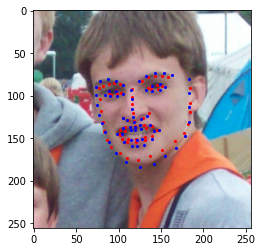

NME Value: 0.06982809969877926
Time taken for inference of image: 10.564800262451172
Time taken for inference of image: 9.236288070678711
Time taken for inference of image: 8.782976150512695
Time taken for inference of image: 9.050911903381348
Time taken for inference of image: 8.496064186096191
Time taken for inference of image: 8.673088073730469
Time taken for inference of image: 9.600095748901367
Time taken for inference of image: 8.87945556640625
Time taken for inference of image: 9.050239562988281
Time taken for inference of image: 8.755807876586914
Time taken for inference of image: 8.752991676330566
Time taken for inference of image: 10.025535583496094
Time taken for inference of image: 9.62384033203125
Time taken for inference of image: 8.762528419494629
Time taken for inference of image: 8.591808319091797
Time taken for inference of image: 9.116415977478027
Time taken for inference of image: 8.607583999633789
Time taken for inference of image: 8.60643196105957
Time taken for i

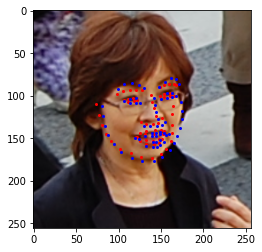

NME Value: 0.09089563053104942
Time taken for inference of image: 10.385791778564453
Time taken for inference of image: 9.688799858093262
Time taken for inference of image: 9.100223541259766
Time taken for inference of image: 9.560959815979004
Time taken for inference of image: 10.263872146606445
Time taken for inference of image: 9.198240280151367
Time taken for inference of image: 12.678560256958008
Time taken for inference of image: 9.733823776245117
Time taken for inference of image: 8.71513557434082
Time taken for inference of image: 8.691455841064453
Time taken for inference of image: 8.606559753417969
Time taken for inference of image: 11.768256187438965
Time taken for inference of image: 9.678655624389648
Time taken for inference of image: 10.23846435546875
Time taken for inference of image: 8.736672401428223
Time taken for inference of image: 8.900896072387695
Time taken for inference of image: 8.78377628326416
Time taken for inference of image: 8.649727821350098
Time taken fo

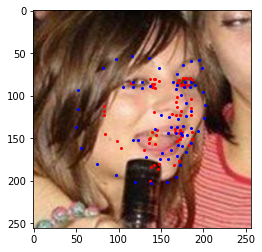

NME Value: 0.17452006012907698
Time taken for inference of image: 10.449919700622559
Time taken for inference of image: 9.066495895385742
Time taken for inference of image: 9.730303764343262
Time taken for inference of image: 8.949695587158203
Time taken for inference of image: 8.974623680114746
Time taken for inference of image: 13.476672172546387
Time taken for inference of image: 8.977312088012695
Time taken for inference of image: 8.842816352844238
Time taken for inference of image: 12.165087699890137
Time taken for inference of image: 9.054752349853516
Time taken for inference of image: 8.750016212463379
Time taken for inference of image: 9.829055786132812
Time taken for inference of image: 8.758687973022461
Time taken for inference of image: 8.858271598815918
Time taken for inference of image: 9.017184257507324
Time taken for inference of image: 9.033920288085938
Time taken for inference of image: 8.576543807983398
Time taken for inference of image: 8.612288475036621
Time taken f

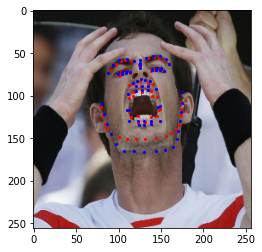

NME Value: 0.09867706354777496
Time taken for inference of image: 9.1778564453125
Time taken for inference of image: 8.835488319396973
Time taken for inference of image: 8.849632263183594
Time taken for inference of image: 8.928640365600586
Time taken for inference of image: 8.83955192565918
Time taken for inference of image: 12.038016319274902
Time taken for inference of image: 9.944735527038574
Time taken for inference of image: 9.981792449951172
Time taken for inference of image: 8.794336318969727
Time taken for inference of image: 9.088000297546387
Time taken for inference of image: 8.810912132263184
Time taken for inference of image: 8.634143829345703
Time taken for inference of image: 8.968992233276367
Time taken for inference of image: 13.127488136291504
Time taken for inference of image: 10.15334415435791
Time taken for inference of image: 9.307488441467285
Time taken for inference of image: 8.791839599609375
Time taken for inference of image: 9.09113597869873
Time taken for in

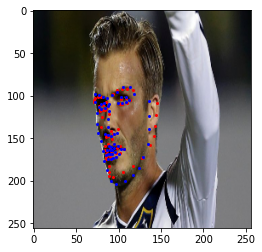

NME Value: 0.14786406297766566
Time taken for inference of image: 10.168607711791992
Time taken for inference of image: 8.810815811157227
Time taken for inference of image: 10.44041633605957
Time taken for inference of image: 8.609439849853516
Time taken for inference of image: 8.845696449279785
Time taken for inference of image: 9.96828842163086
Time taken for inference of image: 9.838687896728516
Time taken for inference of image: 8.888480186462402
Time taken for inference of image: 8.465727806091309
Time taken for inference of image: 8.760031700134277
Time taken for inference of image: 8.696000099182129
Time taken for inference of image: 9.16483211517334
Time taken for inference of image: 8.529215812683105
Time taken for inference of image: 8.680031776428223
Time taken for inference of image: 8.632096290588379
Time taken for inference of image: 14.231552124023438
Time taken for inference of image: 9.811936378479004
Time taken for inference of image: 9.26966381072998
Time taken for i

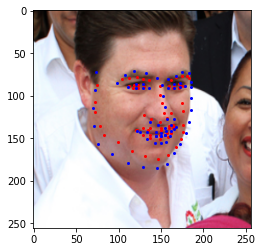

NME Value: 0.10629809920222978
Time taken for inference of image: 10.899231910705566
Time taken for inference of image: 10.379648208618164
Time taken for inference of image: 9.501472473144531
Time taken for inference of image: 9.344223976135254
Time taken for inference of image: 9.139488220214844
Time taken for inference of image: 8.803359985351562
Time taken for inference of image: 10.252639770507812
Time taken for inference of image: 10.550751686096191
Time taken for inference of image: 9.584959983825684
Time taken for inference of image: 8.82534408569336
Time taken for inference of image: 8.681183815002441
Time taken for inference of image: 9.196415901184082
Time taken for inference of image: 9.003744125366211
Time taken for inference of image: 9.232416152954102
Time taken for inference of image: 9.090239524841309
Time taken for inference of image: 9.408127784729004
Time taken for inference of image: 10.342687606811523
Time taken for inference of image: 10.397760391235352
Time taken

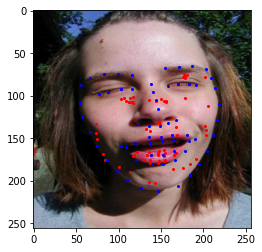

NME Value: 0.15783199632039827
Time taken for inference of image: 10.603903770446777
Time taken for inference of image: 9.928959846496582
Time taken for inference of image: 9.026144027709961
Time taken for inference of image: 9.021280288696289
Time taken for inference of image: 8.63708782196045
Time taken for inference of image: 8.758720397949219
Time taken for inference of image: 8.587648391723633
Time taken for inference of image: 11.501888275146484
Time taken for inference of image: 9.65494441986084
Time taken for inference of image: 8.459775924682617
Time taken for inference of image: 10.013824462890625
Time taken for inference of image: 8.537856101989746
Time taken for inference of image: 10.542464256286621
Time taken for inference of image: 8.716896057128906
Time taken for inference of image: 8.647135734558105
Time taken for inference of image: 8.958463668823242
Time taken for inference of image: 9.997440338134766
Time taken for inference of image: 9.29916763305664
Time taken for

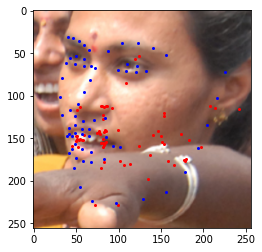

NME Value: 0.6879097286843553
Time taken for inference of image: 10.21190357208252
Time taken for inference of image: 10.120160102844238
Time taken for inference of image: 8.862591743469238
Time taken for inference of image: 8.612832069396973
Time taken for inference of image: 8.52518367767334
Time taken for inference of image: 8.641119956970215
Time taken for inference of image: 8.57151985168457
Time taken for inference of image: 9.962335586547852
Time taken for inference of image: 10.898367881774902
Time taken for inference of image: 9.651552200317383
Time taken for inference of image: 9.30288028717041
Time taken for inference of image: 8.97321605682373
Time taken for inference of image: 8.862144470214844
Time taken for inference of image: 9.092479705810547
Time taken for inference of image: 9.683391571044922
Time taken for inference of image: 9.626272201538086
Time taken for inference of image: 8.56009578704834
Time taken for inference of image: 8.8307523727417
Time taken for infere

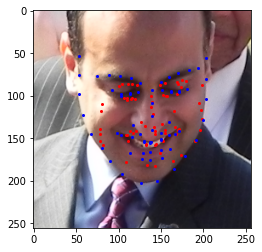

NME Value: 0.1613462462346999
Time taken for inference of image: 10.104096412658691
Time taken for inference of image: 10.104096412658691
Time taken for inference of image: 9.96777629852295
Time taken for inference of image: 8.969535827636719
Time taken for inference of image: 8.57590389251709
Time taken for inference of image: 8.482239723205566
Time taken for inference of image: 8.786879539489746
Time taken for inference of image: 8.489727973937988
Time taken for inference of image: 8.688223838806152
Time taken for inference of image: 9.084671974182129
Time taken for inference of image: 8.579551696777344
Time taken for inference of image: 8.722880363464355
Time taken for inference of image: 9.00387191772461
Time taken for inference of image: 11.26966381072998
Time taken for inference of image: 8.83414363861084
Time taken for inference of image: 9.028639793395996
Time taken for inference of image: 8.842047691345215
Time taken for inference of image: 8.679903984069824
Time taken for inf

In [ ]:
#@title Testing:
RANDOM_SEED = 26

class FaceKeypointTestDataset(Dataset):
    def __init__(self, path):
      ind_names = np.array([])
      out_names = np.array([])
      for f in os.listdir(path + "/01_Indoor"):
        if not '.pts' in f:
          ind_names = np.append(ind_names, "/01_Indoor/" + f)
      for f in os.listdir(path + "/02_Outdoor"):
        if not '.pts' in f:
          out_names = np.append(out_names, '/02_Outdoor/' + f)
      self.ind_data = ind_names
      self.out_data = out_names
      self.path = path

    def __len__(self):
        return len(self.data)

    def get_300W_item(self, name):
      pathname = self.path + name
      image = cv2.imread(pathname)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      orig_h, orig_w, channel = image.shape
      image = cv2.resize(image, (cfg.input_size, cfg.input_size))

      idx = [idx for idx, x in enumerate(pathname) if x == '.']
      keyname = pathname[0:idx[0]] + ".pts"
      keypoints = np.loadtxt(keyname, dtype=float, comments=("version:", "n_points:", "{", "}"))
      # reshape the keypoints
      keypoints.reshape(68, 2)
      # normalize keypoints:
      keypoints = keypoints * [1 / orig_w, 1 / orig_h]
      return image, keypoints
      

    def get_300W_Data(self):
      np.random.seed(RANDOM_SEED)
      np.random.shuffle(self.ind_data)
      np.random.shuffle(self.out_data)
      #use a randomized 500 ims from outdoor images and a randomized 500 from indoor images
      data = np.append(self.ind_data[0:500], self.out_data[0:500]) 
      return data



load_weights = True
weight_file = 'drive/MyDrive/machine-learning/PIPNet/pipnet_epoch54_train10k-augmentations.pth'

meanface_indices, reverse_index1, reverse_index2, max_len = get_meanface('meanface.txt', cfg.num_nb)
    
if load_weights:
  resnet18 = models.resnet18(pretrained=cfg.pretrained)
  net = Pip_resnet18(resnet18, cfg.num_nb, num_lms=cfg.num_lms, input_size=cfg.input_size, net_stride=cfg.net_stride)
  state_dict = torch.load(weight_file)
  net.load_state_dict(state_dict)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
net = net.to(device)

testdata = FaceKeypointTestDataset(cfg.test_data_dir)
dataframe = testdata.get_300W_Data()
nme = []
count = 0

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([transforms.Resize((cfg.input_size, cfg.input_size)), transforms.ToTensor(), normalize])
time_all = 0

starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

for n in dataframe:
  image, keypoints = testdata.get_300W_item(n)

  norm = np.linalg.norm(keypoints[36] - keypoints[45])

  inputs = Image.fromarray(image[:,:,::-1].astype('uint8'), 'RGB')
  inputs = preprocess(inputs).unsqueeze(0)
  inputs = inputs.to(device)

  t1 = time.time()
  starter.record()

  lms_pred_x, lms_pred_y, lms_pred_nb_x, lms_pred_nb_y, outputs_cls, max_cls = forward_pip(net, inputs, cfg.input_size, cfg.net_stride, cfg.num_nb)

  lms_pred = torch.cat((lms_pred_x, lms_pred_y), dim=1).flatten()
  tmp_nb_x = lms_pred_nb_x[reverse_index1, reverse_index2].view(cfg.num_lms, max_len)
  tmp_nb_y = lms_pred_nb_y[reverse_index1, reverse_index2].view(cfg.num_lms, max_len)
  tmp_x = torch.mean(torch.cat((lms_pred_x, tmp_nb_x), dim=1), dim=1).view(-1,1)
  tmp_y = torch.mean(torch.cat((lms_pred_y, tmp_nb_y), dim=1), dim=1).view(-1,1)
  lms_pred_merge = torch.cat((tmp_x, tmp_y), dim=1).flatten()

  ender.record()
  torch.cuda.synchronize()
  curr_time = starter.elapsed_time(ender)

  t2 = time.time()
  #time_all += (t2-t1)
  time_all += (curr_time)

  

  lms_pred = lms_pred.cpu().numpy()
  lms_pred_merge = lms_pred_merge.cpu().numpy()

  #nme_std = compute_nme(lms_pred, lms_gt, norm)
  #nmes_std.append(nme_std)
  lms_gt = np.reshape(keypoints, (1,keypoints.shape[0]*2))
  lms_gt = lms_gt[0]
  #print(lms_pred_merge.shape)
  #print(lms_gt.shape)
  nme_merge = compute_nme(lms_pred_merge, lms_gt, norm)
  nme.append(nme_merge)

  preds = np.reshape(lms_pred, (len(lms_pred)//2, 2))
  truths = np.reshape(lms_gt, (len(lms_gt)//2, 2))

  print("Time taken for inference of image: " + str(curr_time))

  if count % 20 == 0:
    plt.imshow(image)
    plt.plot(preds[:,0]*cfg.input_size,preds[:,1]*cfg.input_size, 'ro', markersize = 2)
    plt.plot(truths[:,0]*cfg.input_size,truths[:,1]*cfg.input_size, 'bo', markersize = 2)
    plt.show()  
    print("NME Value: " + str(nme_merge));

  count += 1


nme = np.array(nme)
print("Average NME: " + str(np.mean(nme)))
print("Total Time: " + str(time_all))
print(time_all/1000)

In [ ]:
#@title Video Test

meanface_indices, reverse_index1, reverse_index2, max_len = get_meanface(os.path.join('meanface.txt'), cfg.num_nb)


#if cfg.backbone == 'resnet18':
#    resnet18 = models.resnet18(pretrained=cfg.pretrained)
#    net = Pip_resnet18(resnet18, cfg.num_nb, num_lms=cfg.num_lms, input_size=cfg.input_size, net_stride=cfg.net_stride)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

#weight_file = os.path.join(save_dir, 'epoch%d.pth' % (cfg.num_epochs-1))
#state_dict = torch.load(weight_file, map_location=device)
#net.load_state_dict(state_dict)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([transforms.Resize((cfg.input_size, cfg.input_size)), transforms.ToTensor(), normalize])

def demo_video(video_file, net, preprocess, input_size, net_stride, num_nb, use_gpu, device):
    #detector = FaceBoxesDetector('FaceBoxes', 'FaceBoxesV2/weights/FaceBoxesV2.pth', use_gpu, device)
    my_thresh = 0.9
    det_box_scale = 1.2

    net.eval()
    if video_file == 'camera':
        cap = cv2.VideoCapture(0)
    else:
        cap = cv2.VideoCapture(video_file)
    if (cap.isOpened()== False): 
        print("Error opening video stream or file")
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    count = 0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            inputs = Image.fromarray(frame[:,:,::-1].astype('uint8'), 'RGB')
            inputs = preprocess(inputs).unsqueeze(0)
            inputs = inputs.to(device)
            lms_pred_x, lms_pred_y, lms_pred_nb_x, lms_pred_nb_y, outputs_cls, max_cls = forward_pip(net, inputs, input_size, net_stride, num_nb)
            lms_pred = torch.cat((lms_pred_x, lms_pred_y), dim=1).flatten()
            tmp_nb_x = lms_pred_nb_x[reverse_index1, reverse_index2].view(cfg.num_lms, max_len)
            tmp_nb_y = lms_pred_nb_y[reverse_index1, reverse_index2].view(cfg.num_lms, max_len)
            tmp_x = torch.mean(torch.cat((lms_pred_x, tmp_nb_x), dim=1), dim=1).view(-1,1)
            tmp_y = torch.mean(torch.cat((lms_pred_y, tmp_nb_y), dim=1), dim=1).view(-1,1)
            lms_pred_merge = torch.cat((tmp_x, tmp_y), dim=1).flatten()
            lms_pred = lms_pred.cpu().numpy()
            lms_pred_merge = lms_pred_merge.cpu().numpy()
            for i in range(cfg.num_lms):
                x_pred = lms_pred_merge[i*2]*frame_width
                y_pred = lms_pred_merge[i*2+1]*frame_height
                cv2.circle(frame, (int(x_pred), int(y_pred)), 1, (0, 0, 255), 2)
                
            count += 1
            cv2.imwrite('drive/MyDrive/test-video-frames/'+str(count)+'.jpg', frame)
            #cv2.imshow('1', frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break

    cap.release()
    cv2.destroyAllWindows()

video_file = 'drive/MyDrive/007.avi'



demo_video(video_file, net, preprocess, cfg.input_size, cfg.net_stride, cfg.num_nb, cfg.use_gpu, device)


<ipython-input-9-9379ba8c1b38>:236: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_y = (max_ids//tmp_width).view(-1,1).float()+outputs_y_select.view(-1,1)
<ipython-input-9-9379ba8c1b38>:241: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_nb_y = (max_ids//tmp_width).view(-1,1).float()+outputs_nb_y_select


In [ ]:
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    frame = cv2.cvtColor(src=frame, code=cv2.COLOR_BGR2RGB)
    cv2.imshow('webcam', frame)
# press escape to exit
    if (cv2.waitKey(30) == 27):
       break
cap.release()
cv2.destroyAllWindows()